## ASTRO 596: The Final Exam

Alex Gagliano, 05/10/2020

Let's start by importing our required packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from astropy.time import Time
from collections import Counter

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Dark2")

We clean the data a bit by removing times long before the supernova and magnitudes that haven't been zeropoint corrected. 

In [2]:
data = pd.read_csv("../data/2020oi_data.snana.txt", delimiter='\t')
data = data[data['MJD'] > 57000]
data = data[data['MAG'] > 0]

Now let's visualize our data. 

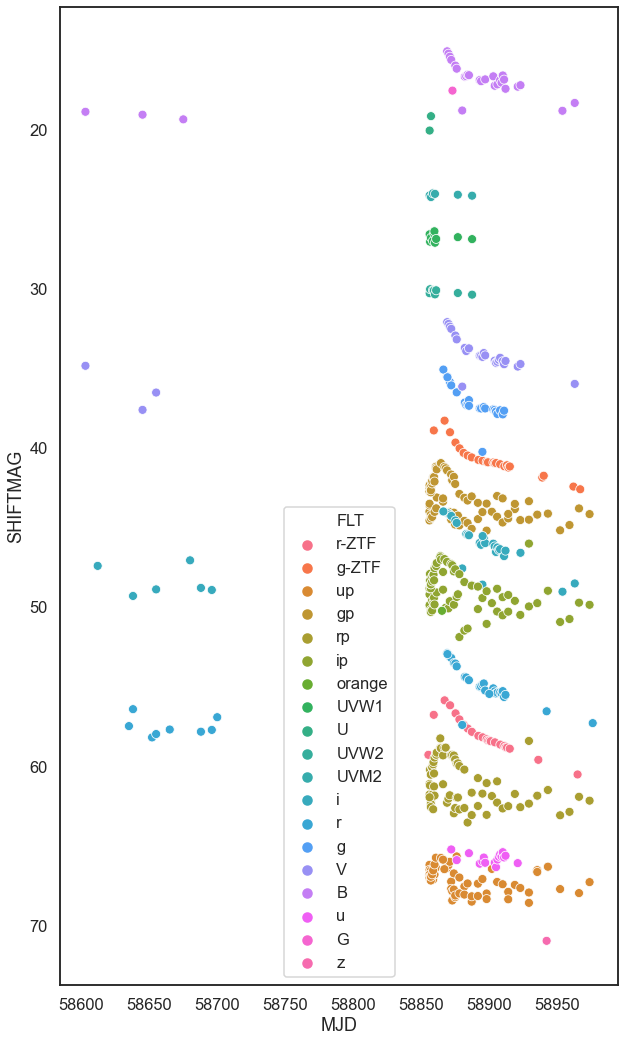

In [3]:
bands = np.unique(data['FLT'])
data['SHIFTMAG'] = data['MAG']
plt.figure(figsize=(10,18))
for i in np.arange(19):
    data.loc[data['FLT'] == bands[i], 'SHIFTMAG'] +=  3*i 
sns.scatterplot(x='MJD', y='SHIFTMAG', hue='FLT', data=data)
plt.gca().invert_yaxis()

How many data points were collected by a given instrument? 

In [4]:
Counter(data['INSTRUMENT'])

Counter({'ZTF-Cam': 48,
         'Sinistro': 323,
         'HKO': 1,
         'UVOT': 26,
         'GPC1': 8,
         'Direct/4Kx4K': 137,
         'Gaia-Photometric': 1,
         'Direct/2Kx2K': 31})

Up to here, we've only considered the publically released data from YSE PZ. Let's now look at the optical data that Charlie and I have been reducing with Swope templates. 

In [5]:
import os
from os import listdir
from os.path import isfile, join
from astropy.io import fits
import warnings
from astropy.utils.exceptions import AstropyUserWarning
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=AstropyUserWarning)
warnings.filterwarnings('ignore', category=AstropyWarning)

#rough position of the supernova at the center of the image, in pixels: 
#2251, 2251
XSN = 2251
YSN = 2251

timeArr = []
fixed_optical_df = []
zpts = []
zpts00 = []
path = "/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/"
files = [f for f in listdir(path) if isfile(join(path, f))]
#get the REAL photometry:
header_list = ['Xpos','Ypos','Mag','Mag_err','flux','flux_err', 'type', 'peakflux', 'sigx', 'sigxy', 'sigy', 'sky','chisqr','class','FWHM1','FWHM2','FWHM','angle','extendedness','flag','mask','Nmask','RA','Dec','pixchk_Npos','pixchk_Nneg','pixchk_Nmask','pixchk_Ntot','pixchk_Fpos','pixchk_Fneg']
dict_vals = {}
bands = []
for file in files:
    bands.append(file[7])
    hdul = fits.open("/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/%s"%file)
    temp = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/%s"%file, names=header_list, skiprows=1, delim_whitespace=True)
    sub = temp[np.abs(temp['Xpos'] - XSN) + np.abs(temp['Xpos'] - YSN)  < 3]
    sub = sub[sub['peakflux'] == np.max(sub['peakflux'].values)]
    timeArr.append(hdul[0].header['MJD-OBS'])
    zpts.append(hdul[0].header['ZPTMAGAV'])
    if hdul[0].header['ZPTMAGAV'] < 1:
        print(file)
    zpts00.append(hdul[0].header['ZPTMAG00'])
    fixed_optical_df.append(sub)

2020oi.i.ut200216.4071_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.i.ut200120.1130_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.r.ut200314.3141_stch_1_r.2020oitmpl.19.stk_1.diff.dcmp
2020oi.i.ut200301.8104_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.i.ut200204.3125_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.r.ut200303.1098_stch_1_r.2020oitmpl.19.stk_1.diff.dcmp


In [6]:
fixed_optical_df = pd.concat(fixed_optical_df, ignore_index=True)
fixed_optical_df['time'] = timeArr
fixed_optical_df['zpt_av'] = zpts
fixed_optical_df['zpt_00'] = zpts00

fixed_optical_df['band'] = bands

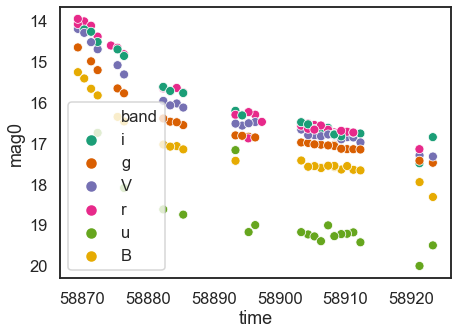

In [7]:
fixed_optical_df['mag0'] = -2.5*np.log10(fixed_optical_df['flux']) + fixed_optical_df['zpt_av']

#dropping the failed points for now
fixed_optical_df = fixed_optical_df[fixed_optical_df['mag0'] > 0]

plt.figure(figsize=(7,5))
sns.set_context("talk")
sns.scatterplot('time', 'mag0', hue='band', data=fixed_optical_df)
plt.gca().invert_yaxis()

fixed_optical_df['MJD'] = fixed_optical_df['time']
fixed_optical_df['MAG'] = fixed_optical_df['mag0']
fixed_optical_df['MAGERR'] = fixed_optical_df['Mag_err']
fixed_optical_df['FLT'] = fixed_optical_df['band']
newData = fixed_optical_df[['MJD', 'MAG', 'MAGERR', 'FLT']]

Looks a lot cleaner! How many bands do we have from the public data? 

In [8]:
from collections import Counter
Counter(data['FLT'])

Counter({'r-ZTF': 24,
         'g-ZTF': 24,
         'up': 70,
         'gp': 86,
         'rp': 82,
         'ip': 85,
         'orange': 1,
         'UVW1': 10,
         'U': 2,
         'UVW2': 8,
         'UVM2': 6,
         'i': 36,
         'r': 37,
         'g': 24,
         'V': 30,
         'B': 30,
         'u': 18,
         'G': 1,
         'z': 1})

To start looking into a GP, let's first consider the r-band, which should have some of the most data. We're going to consolidate data collected in 'rp', 'r-ZTF', and 'r' band - these are instrument specific names for similar bands (is this fair game to do?). 

In [9]:
bands_list = [['rp', 'r-ZTF', 'r'], ['gp', 'g-ZTF', 'g'], ['B'], ['u', 'up'], ['U'], ['UVW2'], ['UVM2'], ['V'], ['i', 'ip']]
bands = ['rp', 'r-ZTF', 'r']

oneBand = data[data['FLT'].isin(bands)]
newData = newData[newData['FLT'].isin(bands)]
oneBand.sort_values(by=['MJD'], inplace=True)
oneBand = oneBand[oneBand['MAGERR'] < 0.03]
oneBand = oneBand[oneBand['MJD'] > 58800]

#combine online data plus newly reduced Swope photometry
oneBand = pd.concat([oneBand, newData])
#make sure our observations are unique
oneBand.drop_duplicates(subset=['MJD', 'MAG'], inplace=True)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


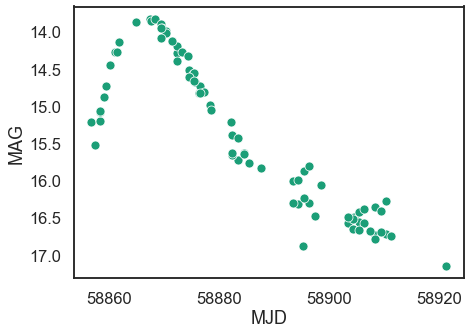

In [10]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='MJD', y='MAG',data=oneBand);
plt.gca().invert_yaxis()

When does the supernova peak in the 'r'? 

In [11]:
peakTime = oneBand.loc[oneBand['MAG'] == np.min(oneBand['MAG']), 'MJD'].values[0]

For fitting, we now separate into rise, peak, and fall components of the supernova lightcurve. 

In [12]:
#get the points with lowest error
oneBand.sort_values(by=['MJD'], inplace=True)
rise = oneBand[oneBand['MJD'] < peakTime]
peak = oneBand[np.abs(oneBand['MJD'] - peakTime) < 0.2]
fall = oneBand[oneBand['MJD'] > peakTime]

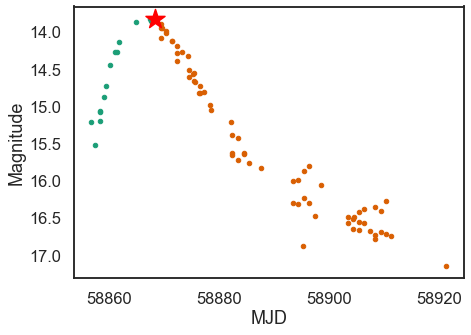

In [13]:
plt.figure(figsize=(7,5))
plt.plot(rise['MJD'], rise['MAG'], '.')
plt.scatter(peak['MJD'], peak['MAG'], marker='*', s=400, zorder=100, c='r')
plt.plot(fall['MJD'], fall['MAG'], '.')
plt.xlabel("MJD")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()

And, fitting both the rise and decline: 

In [14]:
zRise = np.polyfit(rise['MJD'].values.astype(float), rise['MAG'].values, 2)
zFall = np.polyfit(fall['MJD'].values.astype(float), fall['MAG'].values, 2)

In [15]:
def fit(time):
    PT = peak['MJD'].values
    time = np.array(time)
    riseTimes = time[time <= PT]
    fallTimes = time[time > PT]
    riseMag = zRise[2] + zRise[1]*riseTimes + zRise[0]*riseTimes**2
    fallMag = zFall[2] + zFall[1]*fallTimes + zFall[0]*fallTimes**2 #+ zFall[0]*fallTimes**3
    mag = np.concatenate([riseMag, fallMag])
    return mag

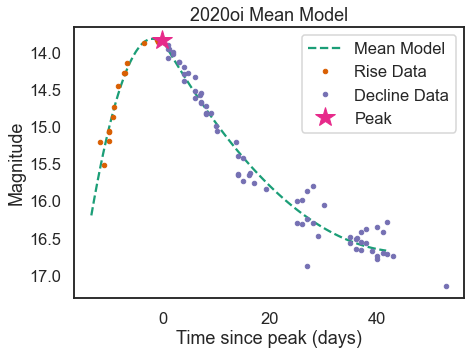

In [16]:
newTime = np.linspace(58855, 58910,num=100)
plt.figure(figsize=(7,5))
plt.plot(newTime-peakTime, fit(newTime), '--',label='Mean Model');
plt.plot(rise['MJD'].values-peakTime, rise['MAG'].values, '.', label='Rise Data');
plt.plot(fall['MJD'].values-peakTime, fall['MAG'].values, '.', label='Decline Data');
plt.plot(peak['MJD'].values-peakTime, peak['MAG'].values, '*', markersize=20, label='Peak');
plt.gca().invert_yaxis()
plt.xlabel("Time since peak (days)")
plt.ylabel("Magnitude")
plt.title("2020oi Mean Model")
plt.legend();
plt.savefig("MeanModel_Alex.png", bbox_inches='tight')

A pretty good fit! This will serve as our mean model for this data - we'll now use George to create a gaussian process to fit the data a little more closely. 

In [17]:
import george
from george.modeling import Model

class MeanModel(Model):
    parameter_names = ('r1', 'r2', 'r3', 'f1', 'f2', 'f3')
    def get_parameter_vector(self):
        return np.array([self.r1, self.r2, self.r3, self.f1, self.f2, self.f3])
    def set_vector(self, vec):
        self.r1 = vec[0]
        self.r2 = vec[1]
        self.r3 = vec[2]
        self.f1 = vec[3]
        self.f2 = vec[4]
        self.f3 = vec[5]
        #k.set_parameter_vector(k.get_parameter_vector() + np.random.randn(2))
    def set_parameter_vector(self, vec): 
        return set_vector(self, vec)
    def get_value(self, time):
        PT = peak['MJD'].values
        time = np.array(time)
        riseTimes = time[time <= PT]
        fallTimes = time[time > PT]
        riseMag = self.r3 + self.r2*riseTimes + self.r1*riseTimes**2
        fallMag = self.f3 + self.f2*fallTimes + self.f1*fallTimes**2 
        soln = np.concatenate([riseMag, fallMag])
        return soln

In [18]:
#our starting vector will be composed of the best-fit values for the rise and the decline
p0 = np.concatenate([zRise, zFall])

In [19]:
def lnprob(p):
    #let's make them all flat priors - 
    logBoundL = np.array([1.e-4, -1.e3, 1.e7, 1.e-4, -1.e3, 1.e6])
    logBoundR = np.array([1.e-3, -1.e2, 5.e7, 1.e-3, -1.e2, 5.e6])
    for i in np.arange(6):
        if (p[i] < logBoundL[i]) or (p[i] > logBoundR[i]):
            return -np.inf
    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.lnlikelihood(oneBand['MAG'], quiet=True)

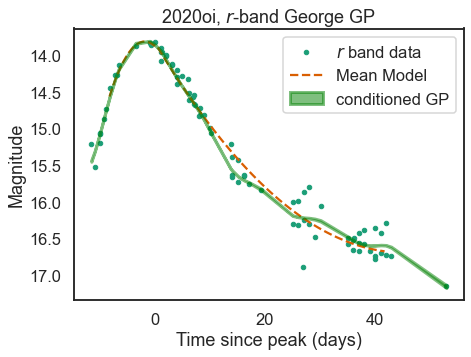

In [20]:
import scipy.optimize as op
from george import kernels

kernel = kernels.ExpSquaredKernel(50.0)

gp = george.GP(mean=MeanModel(r1=zRise[0], r2=zRise[1], r3=zRise[2], f1=zFall[0], f2=zFall[1], f3=zFall[2]), kernel=kernel)

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(oneBand['MAG'].values, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(oneBand['MAG'].values, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(oneBand['MJD'].values, oneBand['MAGERR'].values)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

ypred2, cov = gp.predict(oneBand['MAG'].values, oneBand['MJD'].values, return_cov=True)
std = np.sqrt(np.diag(cov))

# plot the data
plt.figure(figsize=(7,5))
plt.fill_between(oneBand['MJD'].values-peakTime, ypred2+std, ypred2-std, color="g", lw=3, alpha=0.5, label='conditioned GP', zorder=100)
newTime = np.linspace(58860, 58910,num=100)
plt.plot(oneBand['MJD'].values-peakTime, oneBand['MAG'].values, '.', label=r'$r$ band data');
plt.plot(newTime-peakTime, fit(newTime), '--',label='Mean Model');
#plt.plot(rise['MJD'].values, rise['MAG'].values, 'o', label='Rise Data');
#plt.plot(fall['MJD'].values, fall['MAG'].values, 'o', label='Decline Data');
#plt.plot(peak['MJD'].values, peak['MAG'].values, '*', markersize=20, zorder=100, label='Peak');
plt.gca().invert_yaxis()
plt.xlabel("Time since peak (days)")
plt.ylabel("Magnitude")
plt.legend(loc='upper right');
plt.title("2020oi, $r$-band George GP")
plt.savefig("George_GP_Alex.png", bbox_inches='tight')

This looks good! We can argue that the data is still a little more scattered than we'd like, but the GP did the best it could. Unfortunately, we're going to have to do this same thing in pymc3 so that we can construct a hierarchical model. 

First, we define a mean model...

In [21]:
import theano.tensor as tt
import pymc3 as pm

class MeanModel(pm.gp.mean.Mean):

    def __init__(self, r1, r2, r3, f1, f2, f3):
        #Mean.__init__(self)
        self.r1 = r1
        self.r2 = r2
        self.r3 = r3
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3
        self.peak = peak
        
    def __call__(self, X):
        X = np.array(X)
        #PT = self.peak
        PT = peakTime
        riseTimes = X[X <= PT]
        fallTimes = X[X > PT]
        riseMag = self.r3 + self.r2*riseTimes + self.r1*riseTimes**2
        fallMag = self.f3 + self.f2*fallTimes + self.f1*fallTimes**2
        soln = tt.concatenate([riseMag, fallMag])
        return soln

Next, we create our gaussian process. We'll make normally distributed variables for the rise and decline parameters in r-band, each centered upon our scipy-optimized values. 

In [25]:
with pm.Model() as marginal_gp_model:

    l = pm.HalfNormal('l', sigma=20, shape=1)
    cov_func = pm.gp.cov.ExpQuad(1, ls=l)

    # The scale of the white noise term can be provided,
    r1 = pm.Normal('r1', p0[0], sigma=10, shape=1)
    r2 = pm.Normal('r2', p0[1], sigma=10, shape=1)
    r3 = pm.Normal('r3', p0[2], sigma=10, shape=1)
    f1 = pm.Normal('f1', p0[3], sigma=10, shape=1)
    f2 = pm.Normal('f2', p0[4], sigma=10, shape=1)
    f3 = pm.Normal('f3', p0[5], sigma=10, shape=1)
    
   # sigma = pm.HalfCauchy("sigma", beta=1.)
    σ = pm.HalfNormal('σ', 0.5)
    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(MeanModel(r1=r1,r2=r2,r3=r3,f1=f1,f2=f2,f3=f3), cov_func=cov_func)
    y_ = gp.marginal_likelihood("y", X=oneBand['MJD'].values[:, None], y=oneBand['MAG'].values, noise=σ)
    mp = pm.find_MAP()

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -39.227, ||grad|| = 4.2081e+09: 100%|██████████| 8/8 [00:00<00:00, 579.91it/s]


Next, we can generate a new grid of MJD times and see how our model prediction is. 

In [23]:
X_new = np.linspace(58856.698, 58921.23906, 60)[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

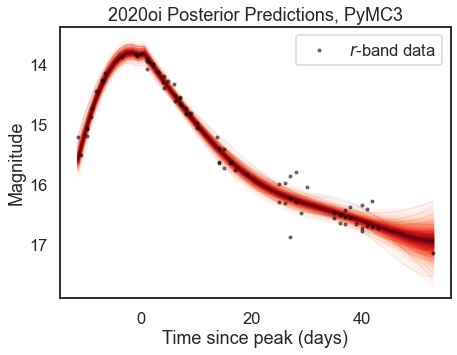

In [24]:
# plot the results
fig = plt.figure(figsize=(7,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new-peakTime);
plt.plot(oneBand['MJD']-peakTime, oneBand['MAG'], 'ok', ms=3, alpha=0.5, label=r"$r$-band data");
plt.xlabel("Time since peak (days)")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis();
plt.legend();
plt.title("2020oi Posterior Predictions, PyMC3")
plt.savefig("PyMC3_oneGP_Alex.png", bbox_inches='tight')

Okay, now let's build up a hierarchical model for all of the bands, making sure we consolidate where bands are similar and exclude the bands containing fewer than 10 data points. 

In [59]:
bands_list = [['rp', 'r-ZTF', 'r'], ['gp', 'g-ZTF', 'g'], ['B'], ['u', 'up'], ['U'], ['UVW2'], ['UVM2'], ['V'], ['i', 'ip']]
newbands_list = bands_list[:]
cleaned_data = []
bands_idx = []
for i in np.arange(len(bands_list)):
    bands = bands_list[i]
    oneBand = data[data['FLT'].isin(bands)]
    newData = newData[newData['FLT'].isin(bands)]
    oneBand.sort_values(by=['MJD'], inplace=True)
    oneBand = oneBand[oneBand['MAGERR'] < 0.1]
    oneBand = oneBand[oneBand['MJD'] > 58800]

    #combine online data plus newly reduced Swope photometry
    oneBand = pd.concat([oneBand, newData], ignore_index=True)
    #make sure our observations are unique
    oneBand.dropna(inplace=True)
    oneBand.drop_duplicates(subset=['MJD', 'MAG'], inplace=True)
    
    #only use if we have enough points for the fitting: 
    if len(oneBand) > 10:
        bands_idx.append(np.ones(len(oneBand))*i)
        cleaned_data.append(oneBand)
    else:
        newbands_list.remove(bands)
bands_idx = np.concatenate(bands_idx)
cleaned_df = pd.concat(cleaned_data, ignore_index=True)
bands_list = newbands_list

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Which bands are left after this culling? 

In [60]:
bands_list

[['rp', 'r-ZTF', 'r'],
 ['gp', 'g-ZTF', 'g'],
 ['B'],
 ['u', 'up'],
 ['V'],
 ['i', 'ip']]

Finally, we construct our hierarchical gaussian process model: 

In [180]:
from pymc3.gp.util import plot_gp_dist

oneBand = cleaned_df[cleaned_df['FLT'].isin(bands)]
with pm.Model() as marginal_gp_model:

    l = pm.HalfNormal('l', sigma=20., shape=6)
    cov_func = pm.gp.cov.ExpQuad(1, ls=l[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=l[1])
    cov_func3 = pm.gp.cov.ExpQuad(1, ls=l[2])
    cov_func4 = pm.gp.cov.ExpQuad(1, ls=l[3])
    cov_func5 = pm.gp.cov.ExpQuad(1, ls=l[4])
    cov_func6 = pm.gp.cov.ExpQuad(1, ls=l[5])

    # The scale of the white noise term can be provided,
    r1 = pm.Normal('r1', p0[0], sigma=10, shape=6)
    r2 = pm.Normal('r2', p0[1], sigma=10, shape=6)
    r3 = pm.Normal('r3', p0[2], sigma=10, shape=6)
    f1 = pm.Normal('f1', p0[3], sigma=10, shape=6)
    f2 = pm.Normal('f2', p0[4], sigma=10, shape=6)
    f3 = pm.Normal('f3', p0[5], sigma=10, shape=6)
    
    gp = pm.gp.Marginal(MeanModel(r1=r1[0],r2=r2[0],r3=r3[0],f1=f1[0],f2=f2[0],f3=f3[0]), cov_func=cov_func)
    gp2 = pm.gp.Marginal(MeanModel(r1=r1[1],r2=r2[1],r3=r3[1],f1=f1[1],f2=f2[1],f3=f3[1]), cov_func=cov_func)
    gp3 = pm.gp.Marginal(MeanModel(r1=r1[2],r2=r2[2],r3=r3[2],f1=f1[2],f2=f2[2],f3=f3[2]), cov_func=cov_func)
    gp4 = pm.gp.Marginal(MeanModel(r1=r1[3],r2=r2[3],r3=r3[3],f1=f1[3],f2=f2[3],f3=f3[3]), cov_func=cov_func)
    gp5 = pm.gp.Marginal(MeanModel(r1=r1[4],r2=r2[4],r3=r3[4],f1=f1[4],f2=f2[4],f3=f3[4]), cov_func=cov_func)
    gp6 = pm.gp.Marginal(MeanModel(r1=r1[5],r2=r2[5],r3=r3[5],f1=f1[5],f2=f2[5],f3=f3[5]), cov_func=cov_func)
 
    # sigma = pm.HalfCauchy("sigma", beta=1.)
    σ = pm.HalfNormal('σ', 0.05, shape=6)
    
    y_ = gp.marginal_likelihood("y", X=cleaned_data[0]['MJD'].values[:, None], y=cleaned_data[0]['MAG'].values, noise=σ[0]) #noise=sigma[0])
    mp = pm.find_MAP()

    y2_ = gp2.marginal_likelihood("y2", X=cleaned_data[1]['MJD'].values[:, None], y=cleaned_data[1]['MAG'].values, noise=σ[1]) #noise=sigma[1])
    mp2 = pm.find_MAP()
    
    y3_ = gp3.marginal_likelihood("y3", X=cleaned_data[2]['MJD'].values[:, None], y=cleaned_data[2]['MAG'].values, noise=σ[2]) #noise=sigma[2])
    mp3 = pm.find_MAP()

    y4_ = gp4.marginal_likelihood("y4", X=cleaned_data[3]['MJD'].values[:, None], y=cleaned_data[3]['MAG'].values, noise=σ[3]) #noise=sigma[3])
    mp4 = pm.find_MAP()

    y5_ = gp5.marginal_likelihood("y5", X=cleaned_data[4]['MJD'].values[:, None], y=cleaned_data[4]['MAG'].values, noise=σ[4]) #noise=sigma[4])
    mp5 = pm.find_MAP()
    
    y6_ = gp6.marginal_likelihood("y6", X=cleaned_data[5]['MJD'].values[:, None], y=cleaned_data[5]['MAG'].values, noise=σ[5]) #noise=sigma[4])
    mp6 = pm.find_MAP()

logp = -910.38, ||grad|| = 18,700: 100%|██████████| 28/28 [00:00<00:00, 527.53it/s]  
logp = -1,946.5, ||grad|| = 1.8262e+07: 100%|██████████| 22/22 [00:00<00:00, 301.26it/s]  
logp = -2,014.8, ||grad|| = 1.1088e+09: 100%|██████████| 24/24 [00:00<00:00, 274.07it/s]  
logp = -2,872.7, ||grad|| = 2.4781e+10: 100%|██████████| 26/26 [00:00<00:00, 221.34it/s]  
logp = -2,901.8, ||grad|| = 3.1497e+08: 100%|██████████| 35/35 [00:00<00:00, 202.11it/s]  
logp = -3,430.3, ||grad|| = 1.5055e+09: 100%|██████████| 38/38 [00:00<00:00, 175.22it/s]  


Let's predict on new data - but we need to make sure we make the new data specific to the bands - if we try to predict far outside of the data ranges for a band, we could run into trouble.

In [181]:
X_new = np.linspace(np.min(cleaned_data[0]['MJD']), np.max(cleaned_data[0]['MJD']), 50)[:,None]
X_new2 = np.linspace(np.min(cleaned_data[1]['MJD']), np.max(cleaned_data[1]['MJD']), 50)[:,None]
X_new3 = np.linspace(np.min(cleaned_data[2]['MJD']), np.max(cleaned_data[2]['MJD']), 50)[:,None]
X_new4 = np.linspace(np.min(cleaned_data[3]['MJD']), np.max(cleaned_data[3]['MJD']), 50)[:,None]
X_new5 =np.linspace(np.min(cleaned_data[4]['MJD']), np.max(cleaned_data[4]['MJD']), 50)[:,None]
X_new6 =np.linspace(np.min(cleaned_data[5]['MJD']), np.max(cleaned_data[5]['MJD']), 50)[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)
    f_pred2 = gp2.conditional("f_pred2", X_new2)
    f_pred3 = gp3.conditional("f_pred3", X_new3)
    f_pred4 = gp4.conditional("f_pred4", X_new4)
    f_pred5 = gp5.conditional("f_pred5", X_new5)
    f_pred6 = gp6.conditional("f_pred6", X_new6)
    
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=500)
    pred_samples2 = pm.sample_posterior_predictive([mp2], vars=[f_pred2], samples=500)
    pred_samples3 = pm.sample_posterior_predictive([mp3], vars=[f_pred3], samples=500)
    pred_samples4 = pm.sample_posterior_predictive([mp4], vars=[f_pred4], samples=500)
    pred_samples5 = pm.sample_posterior_predictive([mp5], vars=[f_pred5], samples=500)
    pred_samples6 = pm.sample_posterior_predictive([mp6], vars=[f_pred6], samples=500)

100%|██████████| 500/500 [00:03<00:00, 129.28it/s]


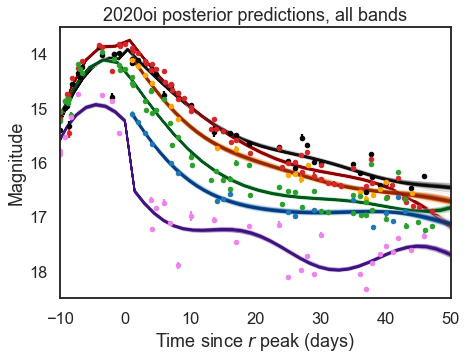

In [182]:
# plot the results
fig = plt.figure(figsize=(7,5)); ax = fig.gca()


# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples6["f_pred6"], X_new6-peakTime, palette = 'Greys');
plt.errorbar(cleaned_data[5]['MJD']-peakTime, cleaned_data[5]['MAG'], yerr=cleaned_data[5]['MAGERR'], fmt='.', label=r"$i_{obs}$", color='k');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples["f_pred"], X_new-peakTime, palette = 'Reds');
plt.errorbar(cleaned_data[0]['MJD']-peakTime, cleaned_data[0]['MAG'], yerr=cleaned_data[0]['MAGERR'], fmt='.',label=r"$r_{obs}$", color='tab:red');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples5["f_pred5"], X_new5-peakTime, palette = 'Oranges');
plt.errorbar(cleaned_data[4]['MJD']-peakTime, cleaned_data[4]['MAG'], yerr=cleaned_data[4]['MAGERR'], fmt='.', label=r"$V_{obs}$", color='orange');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples2["f_pred2"], X_new2-peakTime, palette = 'Greens');
plt.errorbar(cleaned_data[1]['MJD']-peakTime, cleaned_data[1]['MAG'], yerr=cleaned_data[1]['MAGERR'], fmt='.', label=r"$g_{obs}$", color='tab:green');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples3["f_pred3"], X_new3-peakTime, palette = 'Blues');
plt.errorbar(cleaned_data[2]['MJD']-peakTime, cleaned_data[2]['MAG'], yerr=cleaned_data[2]['MAGERR'], fmt='.', label=r"$B_{obs}$", color='tab:blue');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples4["f_pred4"], X_new4-peakTime, palette = 'Purples');
plt.errorbar(cleaned_data[3]['MJD']-peakTime, cleaned_data[3]['MAG'], yerr=cleaned_data[3]['MAGERR'], fmt='.', label=r"$u_{obs}$", color='violet');

plt.xlabel("Time since $r$ peak (days)")
plt.ylabel("Magnitude")
plt.title("2020oi posterior predictions, all bands")
#plt.legend()
plt.xlim((-10, 50))
plt.ylim((18.5, 13.5))
plt.savefig("PyMC3_allGPs_Alex.png", bbox_inches='tight')

These fits are looking pretty good, but unfortunately if we're going to use this data for bolometric fitting, we need to evaluate all our bands along the same xgrid: 

In [183]:
X_new = np.linspace(peakTime-10, peakTime+50, 50)[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred7 = gp.conditional("f_pred7", X_new)
    f_pred8 = gp2.conditional("f_pred8", X_new)
    f_pred9 = gp3.conditional("f_pred9", X_new)
    f_pred10 = gp4.conditional("f_pred10", X_new)
    f_pred11 = gp5.conditional("f_pred11", X_new)
    f_pred12 = gp6.conditional("f_pred12", X_new)
    
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples7 = pm.sample_posterior_predictive([mp], vars=[f_pred7], samples=1000)
    pred_samples8 = pm.sample_posterior_predictive([mp2], vars=[f_pred8], samples=1000)
    pred_samples9 = pm.sample_posterior_predictive([mp3], vars=[f_pred9], samples=1000)
    pred_samples10 = pm.sample_posterior_predictive([mp4], vars=[f_pred10], samples=1000)
    pred_samples11 = pm.sample_posterior_predictive([mp5], vars=[f_pred11], samples=1000)
    pred_samples12 = pm.sample_posterior_predictive([mp6], vars=[f_pred12], samples=1000)

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
100%|██████████| 1000/1000 [00:08<00:00, 121.25it/s]


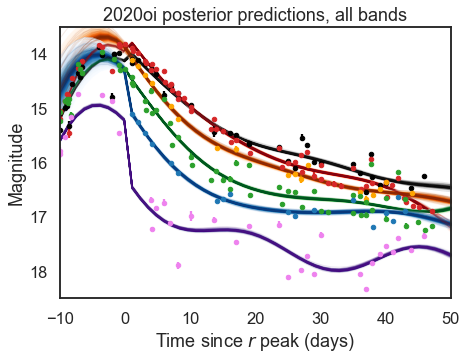

In [184]:
# plot the results
fig = plt.figure(figsize=(7,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples12["f_pred12"], X_new-peakTime, palette = 'Greys');
plt.errorbar(cleaned_data[5]['MJD']-peakTime, cleaned_data[5]['MAG'], yerr=cleaned_data[5]['MAGERR'], fmt='.', label=r"$i_{obs}$", color='k');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples7["f_pred7"], X_new-peakTime, palette = 'Reds');
plt.errorbar(cleaned_data[0]['MJD']-peakTime, cleaned_data[0]['MAG'], yerr=cleaned_data[0]['MAGERR'], fmt='.', label=r"$r_{obs}$", color='tab:red');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples11["f_pred11"], X_new-peakTime, palette = 'Oranges');
plt.errorbar(cleaned_data[4]['MJD']-peakTime, cleaned_data[4]['MAG'], yerr=cleaned_data[4]['MAGERR'], fmt='.', label=r"$V_{obs}$", color='orange');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples8["f_pred8"], X_new-peakTime, palette = 'Greens');
plt.errorbar(cleaned_data[1]['MJD']-peakTime, cleaned_data[1]['MAG'], yerr=cleaned_data[1]['MAGERR'], fmt='.', label=r"$g_{obs}$", color='tab:green');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples9["f_pred9"], X_new-peakTime, palette = 'Blues');
plt.errorbar(cleaned_data[2]['MJD']-peakTime, cleaned_data[2]['MAG'], yerr=cleaned_data[2]['MAGERR'], fmt='.', label=r"$B_{obs}$", color='tab:blue');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples10["f_pred10"], X_new-peakTime, palette = 'Purples');
plt.errorbar(cleaned_data[3]['MJD']-peakTime, cleaned_data[3]['MAG'], yerr=cleaned_data[3]['MAGERR'], fmt='.', label=r"$u_{obs}$", color='violet');

plt.xlabel(r"Time since $r$ peak (days)")
plt.ylabel("Magnitude")
plt.title("2020oi posterior predictions, all bands")
plt.xlim((-10, 50))
plt.ylim((18.5, 13.5))
#plt.legend()
plt.savefig("PyMC3_allGPs_SameX_Alex.png", bbox_inches='tight')

As we expected, the fits are a bit worse outside of their ranges, but I think they're the best we're going to get. Taking the median posteriors as our predicted lightcurves in each band: 

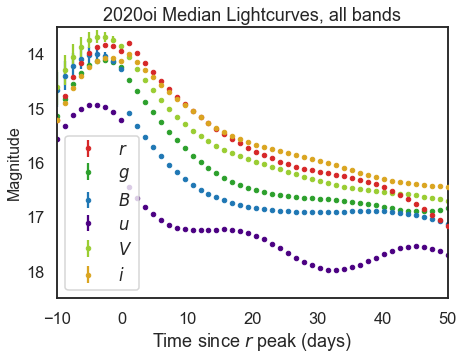

In [185]:
# plot the results
fig = plt.figure(figsize=(7,5)); ax = fig.gca()

#plt.plot(cleaned_data[0]['MJD']-peakTime, cleaned_data[0]['MAG'], 'ok', ms=5,color='tab:blue');
#plt.plot(cleaned_data[1]['MJD']-peakTime, cleaned_data[1]['MAG'], 'ok', ms=5,color='tab:green');
#plt.plot(cleaned_data[2]['MJD']-peakTime, cleaned_data[2]['MAG'], 'ok', ms=5, color='grey');
#plt.plot(cleaned_data[3]['MJD']-peakTime, cleaned_data[3]['MAG'], 'ok', ms=5, color='tab:red');
#plt.plot(cleaned_data[4]['MJD']-peakTime, cleaned_data[4]['MAG'], 'ok', ms=5, color='violet');
#plt.plot(cleaned_data[5]['MJD']-peakTime, cleaned_data[5]['MAG'], 'ok', ms=5, color='violet');

gpLC_r = np.median(pred_samples7['f_pred7'], axis=0)
gpLC_g = np.median(pred_samples8['f_pred8'], axis=0)
gpLC_B = np.median(pred_samples9['f_pred9'], axis=0)
gpLC_U = np.median(pred_samples10['f_pred10'], axis=0)
gpLC_V = np.median(pred_samples11['f_pred11'], axis=0)
gpLC_i = np.median(pred_samples12['f_pred12'], axis=0)

gpLCr_std = np.std(pred_samples7['f_pred7'], axis=0)
gpLCg_std = np.std(pred_samples8['f_pred8'], axis=0)
gpLCB_std = np.std(pred_samples9['f_pred9'], axis=0)
gpLCU_std = np.std(pred_samples10['f_pred10'], axis=0)
gpLCV_std = np.std(pred_samples11['f_pred11'], axis=0)
gpLCi_std = np.std(pred_samples12['f_pred12'], axis=0)

bol_std = np.sqrt(gpLCr_std**2 + gpLCg_std**2 + gpLCB_std**2 + gpLCV_std**2 + gpLCi_std**2 + gpLCU_std**2)

#['r', 'g', 'B', 'u', 'V', 'i']
plt.errorbar(X_new-peakTime, gpLC_r, yerr=gpLCr_std, fmt='.', label=r'$r$', color='tab:red', zorder=100)
plt.errorbar(X_new-peakTime, gpLC_g, yerr=gpLCg_std, fmt='.', label=r'$g$', color='tab:green')
plt.errorbar(X_new-peakTime, gpLC_B, yerr=gpLCB_std, fmt='.', label=r'$B$', color='tab:blue')
plt.errorbar(X_new-peakTime, gpLC_U, yerr=gpLCU_std, fmt='.', label=r'$u$', color='indigo')
plt.errorbar(X_new-peakTime, gpLC_V, yerr=gpLCV_std, fmt='.', label=r'$V$', color='yellowgreen')
plt.errorbar(X_new-peakTime, gpLC_i, yerr=gpLCi_std, fmt='.', label=r'$i$', color='goldenrod', zorder=200)


plt.xlabel(r"Time since $r$ peak (days)")
plt.ylabel("Magnitude",fontsize=16)
plt.title("2020oi Median Lightcurves, all bands")
plt.gca().invert_yaxis()
plt.xlim((-10, 50))
plt.ylim((18.5, 13.5))
plt.legend()
plt.savefig("PyMC3_MedianLCs_Alex.png", bbox_inches='tight')

Cool, the hard part is behind us now. We can convert our interpolated magnitudes to normalized flux, apply flux corrections to flux in each band, and use a trapezoidal interpolation method to get the bolometric lightcurve:

In [186]:
#wavelengths are the centers of each band
wavelengths = np.array([6260, 4830, 4380, 3560, 5450, 7670]) #in Angstroms
c = 3e18 #speed of light, in angstroms/s
#r g B u V i

bol = []
fluxes_arr = []
magserr_arr = []
for i in np.arange(len(X_new)):
    mags = np.array([gpLC_r[i], gpLC_g[i], gpLC_B[i], gpLC_U[i], gpLC_V[i], gpLC_i[i]])
    magserr = np.array([gpLCr_std[i], gpLCg_std[i], gpLCB_std[i], gpLCU_std[i], gpLCV_std[i], gpLCi_std[i]])
    magserr_arr.append(magserr)
    fluxes = 10**((-mags)/2.5) # normalized flux units - do we need to apply the zeropoint??
    fluxes[0] *= 3631.e-23 *c/wavelengths[0]**2  #r correction
    fluxes[1] *= 3631.e-23 *c/wavelengths[1]**2 #g correction, just using r for now
    fluxes[2] *= 632 *1.e-11 #ergs cm^-2 s^-1 Angstroms^-1 #B correction
    fluxes[3] *= 3631.e-23 *c/wavelengths[3]**2 #u correction, just using r for now
    fluxes[4] *= 363.1 *1.e-11 #ergs cm^-2 s^-1 Angstroms^-1#V correction
    fluxes[5] *= 3631.e-23 *c/wavelengths[5]**2#i correction
    fluxes_arr.append(fluxes)
    bol.append(np.trapz(fluxes[np.argsort(wavelengths)], wavelengths[np.argsort(wavelengths)]))

Let's plot it and see how we did. Here we need to convert from bolometric flux to bolometric luminosity, which we can do using the equation: 

$$ L_{bol} = F_{bol}  4 \pi d_{SN}^2$$

Where $d_{SN}$ is the distance to the supernova. SIMBAD gives a host redshift of 0.005251, corresponding to a luminosity distance of 22.7 Mpc, or 7.004e25 cm, so we'll use that. 

Our flux estimate is: 

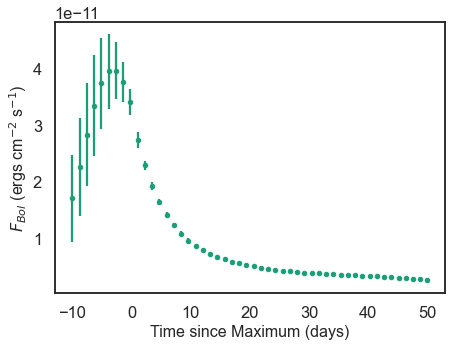

In [187]:
fig = plt.figure(figsize=(7,5)); 
ax = fig.gca()
bol_lum = np.array(bol) #ergs cm^-2 s^-1

# z~ 0.005251 corresponds to a distance of 22.7 Mpc
#error on the flux is roughly the fraction on the flux (and, consequently, the luminosity)
plt.errorbar(X_new-peakTime, bol_lum, yerr=bol_std*bol_lum, fmt='.')
plt.xlabel("Time since Maximum (days)",fontsize=16);
plt.ylabel(r"$F_{Bol}$ (ergs cm$^{-2}$ s$^{-1}$)",fontsize=16);

And our bolometric lightcurve is: 

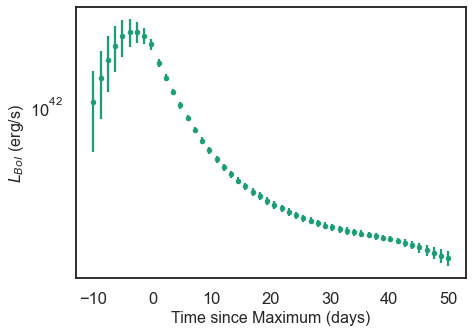

In [188]:
fig = plt.figure(figsize=(7,5)); 
ax = fig.gca()
bol_lum = np.array(bol) * 4 * np.pi * (7.004e25)**2 #ergs cm^-2 s^-1
#bol_lum = np.array(bol) * 4 * np.pi * (7.19e25)**2 #ergs cm^-2 s^-1, from superbol

# z~ 0.005251 corresponds to a distance of 22.7 Mpc
plt.errorbar(X_new-peakTime, bol_lum, yerr=bol_std*bol_lum, fmt='.')
plt.yscale("log")
plt.xlabel("Time since Maximum (days)",fontsize=16);
plt.ylabel(r"$L_{Bol}$ (erg/s)",fontsize=16);

Let's get a rough estimate for the temperature with stefan-boltzmann, assuming a stellar radius of R~1.e15 cm (we are dealing with a massive star, after all). 

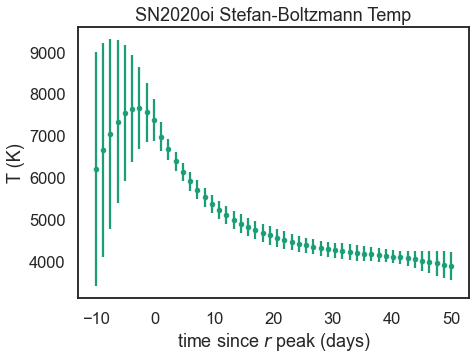

In [198]:
# Getting the temperature (using stefan-boltzmann, assuming R = 1.e15 cm)
fig = plt.figure(figsize=(7,5)); 
sigma =  5.6704e-5# erg⋅cm−2⋅s−1⋅K−4
sb_temp = (bol_lum/(4 * np.pi * (1.e15)**2 * sigma))**(1./4)
plt.errorbar(X_new-peakTime, sb_temp, yerr=bol_std*sb_temp, fmt='.')
plt.xlabel("time since $r$ peak (days)")
plt.ylabel("T (K)")
plt.title("SN2020oi Stefan-Boltzmann Temp")
plt.savefig("sb_Temp_Alex.png", bbox_inches='tight')

# Getting the data ready for superbol:

In [104]:
df_forsuperbol = pd.DataFrame({'MJD':X_new.T[0], 'umag':gpLC_U, 'umagerr': gpLCU_std, 'gmag':gpLC_g, 'gmagerr':gpLCg_std, 'rmag': gpLC_r, 'rmagerr': gpLCr_std, 'imag':gpLC_i, 'imagerr': gpLCi_std})

In [105]:
df_forsuperbol.to_csv("../data/2020oi_ugri.txt", index=False)

In [106]:
df_forsuperbolBV = pd.DataFrame({'MJD':X_new.T[0], 'Bmag':gpLC_B, 'Bmagerr': gpLCB_std, 'Vmag':gpLC_V, 'Vmagerr':gpLCV_std})

In [107]:
df_forsuperbolBV.to_csv("../data/2020oi_BV.txt", index=False)

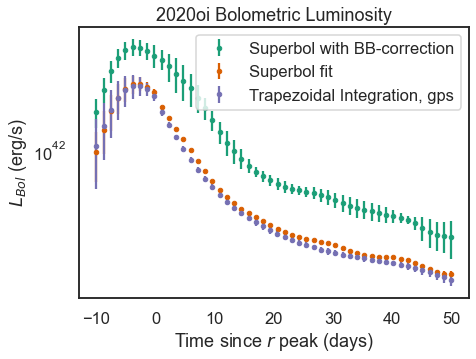

In [199]:
sbol_2020oi = pd.read_csv("../data/bol_2020oi_uBgVri.txt", delimiter='\t')


# z~ 0.005251 corresponds to a distance of 22.7 Mpc #Superbol uses 23.3 Mpc!! 
fig = plt.figure(figsize=(7,5)); 

#plt.semilogy(X_new-peakTime, bol_lum, label='Trapezoidal Integration, gps')
#plt.semilogy(sbol_2020oi['ph']-peakTime, sbol_2020oi['Lobs'], '--', label='Superbol fit')
#plt.semilogy(sbol_2020oi['ph']-peakTime, sbol_2020oi['L+BB'], ':', label='Superbol with BB-correction')
plt.errorbar(sbol_2020oi['ph']-peakTime, sbol_2020oi['L+BB'], yerr=sbol_2020oi['err.1'], fmt='.', label='Superbol with BB-correction')
plt.errorbar(sbol_2020oi['ph']-peakTime, sbol_2020oi['Lobs'], yerr=sbol_2020oi['err'], fmt='.', label='Superbol fit')
#plt.errorbar(BBparams_superbol['ph']-peakTime, BBparams_superbol['L_bb'], yerr=BBparams_superbol['err.2'], fmt='.', label=r'Stefan-Boltzmann');
plt.errorbar(X_new-peakTime, bol_lum, yerr=bol_std*bol_lum, fmt='.', label='Trapezoidal Integration, gps')
plt.yscale("log")
plt.xlabel(r"Time since $r$ peak (days)");
plt.ylabel(r"$L_{Bol}$ (erg/s)");
plt.title("2020oi Bolometric Luminosity")
plt.legend();
plt.savefig("bolometricComparison_Alex.png", bbox_inches='tight', dpi=200)

## A beautiful agreement! Next up - to do a more thorough blackbody temperature and radius fitting: 

In [200]:
#http://rossby.msrc.sunysb.edu/~marat/MAR542/ATM542-Chapter2.pdf
#taken almost directly from superbol
def bb(lamb, T, R):
    h = 6.62607e-27 #cm^2 * g / s
    c = 2.99792458e10 #cm/s
    kB = 1.38064852e-16 # cm^2 * g / s^2 / K
    
    lam_cm = lamb * 1.e-8

    # Calculate Radiance B_lam, in units of (erg / s) / cm ^ 2 / cm
    B_lam = ((2 * np.pi * h * c ** 2) / (lam_cm ** 5)) / (np.exp((h*c)/(lam_cm*kB*T)) - 1)

    Radiance = B_lam * 4*np.pi*R**2 / 1.e8 #(erg / s) / Angstrom

    return Radiance

In [201]:
from scipy.optimize import curve_fit

T = []
R = []
Terr = []
Rerr = []
for i in np.arange(len(fluxes_arr)):
    fluxes = fluxes_arr[i]
    specific_luminosity = fluxes * 4 * np.pi * (7.004e25)**2 #ergs s^-1 Angstroms^-1
    ferr = specific_luminosity * magserr_arr[i]
    BBparams, covar = curve_fit(bb,wavelengths[np.argsort(wavelengths)],specific_luminosity[np.argsort(wavelengths)],p0=(10000,1e15),sigma=ferr[np.argsort(wavelengths)],bounds=(0., [1.e5, 1.e16]))
    perr = np.sqrt(np.diag(covar))

    T.append(BBparams[0])
    R.append(BBparams[1])
    Terr.append(perr[0])
    Rerr.append(perr[1])

In [202]:
BBparams_superbol = pd.read_csv("../data/BB_params_2020oi_uBgVri.txt", delimiter='\t')

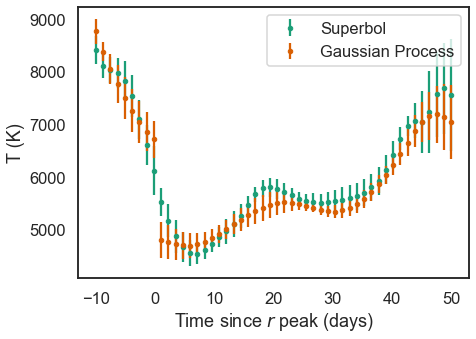

In [203]:
plt.figure(figsize=(7,5))
plt.errorbar(BBparams_superbol['ph']-peakTime, BBparams_superbol['T_bb'], yerr=BBparams_superbol['err'], fmt='.', label=r'Superbol');
plt.errorbar(BBparams_superbol['ph']-peakTime, T, yerr=Terr, fmt='.', label=r'Gaussian Process');
plt.xlabel(r"Time since $r$ peak (days)")
plt.ylabel(r"T (K)")
plt.legend()
plt.savefig("Temp_vs_Superbol_Alex.png", bbox_inches='tight',dpi=200)

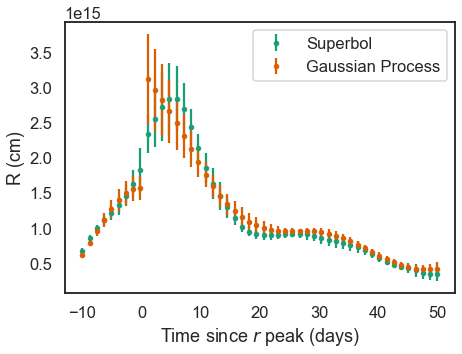

In [204]:
plt.figure(figsize=(7,5))
plt.errorbar(BBparams_superbol['ph']-peakTime, BBparams_superbol['R_bb'], yerr=BBparams_superbol['err.1'], fmt='.', label=r'Superbol');
plt.errorbar(sbol_2020oi['ph']-peakTime, R, yerr=Rerr, fmt='.', label=r'Gaussian Process');
plt.xlabel(r"Time since $r$ peak (days)")
plt.ylabel(r"R (cm)")
plt.legend()
plt.savefig("Radius_vs_Superbol_Alex.png", bbox_inches='tight', dpi=200)

## Hm, this is fairly wonky...future work is to get the fitter working for temp and radius! 